In [1]:
%load_ext nb_black
%load_ext rpy2.ipython

<IPython.core.display.Javascript object>

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from graspologic.datasets import load_mice
from statsmodels.stats.multitest import multipletests

<IPython.core.display.Javascript object>

In [3]:
# Load the full mouse dataset
mice = load_mice()

# Stack all adjacency matrices in a 3D numpy array
graphs = np.array(mice.graphs)

# Sort the connectomes and genotype labels so BTBR is first
label_indices = np.argsort(mice.labels).reshape(4, 8)
label_indices = label_indices[[1, 0, 2, 3]].reshape(-1)
labels = mice.labels[label_indices]
graphs = graphs[label_indices]

# Get sample parameters
n_subjects = mice.meta["n_subjects"]
n_vertices = mice.meta["n_vertices"]

<IPython.core.display.Javascript object>

## Identifying Signal Edges

In [4]:
from hyppo.ksample import KSample

<IPython.core.display.Javascript object>

In [5]:
# Split the set of graphs by genotype
btbr = graphs[labels == "BTBR"]
b6 = graphs[labels == "B6"]
cast = graphs[labels == "CAST"]
dba2 = graphs[labels == "DBA2"]

connectomes = [btbr, b6, cast, dba2]

<IPython.core.display.Javascript object>

In [6]:
# Make iterator for traversing the upper triangle of the connectome
indices = zip(*np.triu_indices(n_vertices, 1))

<IPython.core.display.Javascript object>

In [7]:
edge_pvals = []

for roi_i, roi_j in indices:

    # Get the (i,j)-th edge for each connectome
    samples = [genotype[:, roi_i, roi_j] for genotype in connectomes]

    # Calculate the p-value for the (i,j)-th edge
    try:
        statistic, pvalue = KSample("Dcorr").test(*samples)
    except ValueError:
        # A ValueError is thrown when any of the samples have equal edge
        # weights (i.e. one of the inputs has 0 variance)
        statistic = np.nan
        pvalue = 1

    edge_pvals.append([roi_i + 1, roi_j + 1, statistic, pvalue])

<IPython.core.display.Javascript object>

In [8]:
# Convert the nested list to a dataframe
signal_edges = pd.DataFrame(edge_pvals, columns=["ROI_1", "ROI_2", "stat", "pvalue"])
signal_edges.sort_values(by="pvalue", inplace=True, ignore_index=True)

# Correct p-values
reject, holm_pvalue, _, _ = multipletests(
    signal_edges["pvalue"], alpha=0.05, method="holm"
)
signal_edges["holm_pvalue"] = holm_pvalue
signal_edges["significant"] = reject
signal_edges.sort_values(by="holm_pvalue", inplace=True, ignore_index=True)
signal_edges.to_csv("../results/signal_edges.csv", index=False)
signal_edges.head()

,ROI_1,ROI_2,stat,pvalue,holm_pvalue,significant
0,121,230,0.717036,9.911903e-07,0.054462,False
1,121,293,0.699473,1.327371e-06,0.072932,False
2,121,244,0.698197,1.355858e-06,0.074496,False
3,121,243,0.685735,1.668308e-06,0.091662,False
4,228,287,0.670809,2.139082e-06,0.117525,False


<IPython.core.display.Javascript object>

In [9]:
def lookup_roi_name(roi):
    roi -= 1
    hemisphere = "R" if roi // 166 else "L"
    roi = roi % 166
    structure = mice.atlas["Structure"].values[roi]
    structure = " ".join(structure.split("_"))
    return f"{structure} ({hemisphere})"

<IPython.core.display.Javascript object>

In [10]:
# Get the top 20 strongest signal edges
strong_signal_edges = signal_edges.head(20)
strong_signal_edges["ROI_1"] = strong_signal_edges["ROI_1"].apply(lookup_roi_name)
strong_signal_edges["ROI_2"] = strong_signal_edges["ROI_2"].apply(lookup_roi_name)
strong_signal_edges

,ROI_1,ROI_2,stat,pvalue,holm_pvalue,significant
0,Corpus Callosum (L),Striatum (R),0.717036,9.911903e-07,0.054462,False
1,Corpus Callosum (L),Internal Capsule (R),0.699473,1.327371e-06,0.072932,False
2,Corpus Callosum (L),Reticular Nucleus of Thalamus (R),0.698197,1.355858e-06,0.074496,False
3,Corpus Callosum (L),Zona Incerta (R),0.685735,1.668308e-06,0.091662,False
4,Septum (R),Corpus Callosum (R),0.670809,2.139082e-06,0.117525,False
5,Lateral Ventricle (L),Striatum (R),0.667327,2.266866e-06,0.124544,False
6,Striatum (L),Striatum (R),0.663875,2.401064e-06,0.131914,False
7,Corpus Callosum (L),Ventral Thalamic Nuclei (R),0.663380,2.420987e-06,0.133007,False
8,Hippocampus (L),Middle Cerebellar Peduncle (L),0.658415,2.629842e-06,0.144478,False
9,Caudomedial Entorhinal Cortex (R),Ventral Hippocampal Commissure (R),0.655984,2.738604e-06,0.150451,False


<IPython.core.display.Javascript object>

In [ ]:
def stripplot(df, data_column):

    kwargs = {
        "alpha": 0.75,
        "edgecolor": None,
        "linewidth": 0,
        "marker": "o",
        "palette": ["#e7298a", "#1b9e77", "#d95f02", "#7570b3"],
    }

    fig, ax = plt.subplots(figsize=(2.5, 2.5), dpi=150)

    g = sns.stripplot(
        x="Strain",
        y=data_column,
        data=df,
        jitter=True,
        orient="v",
        ax=ax,
        **kwargs,
    )

    return g

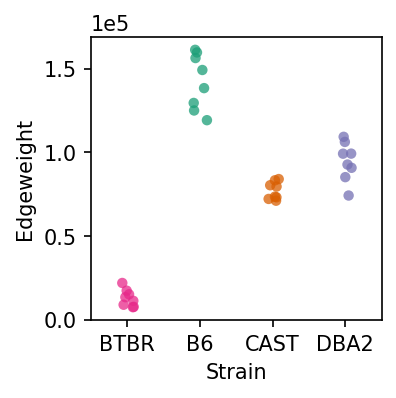

<IPython.core.display.Javascript object>

In [11]:
edgeweight = graphs[:, 121 - 1, 230 - 1]
edgeweight = pd.DataFrame({"Edgeweight": edgeweight, "Strain": labels})
g = stripplot(edgeweight, "Edgeweight")
g.ticklabel_format(style="sci", scilimits=(0, 0), axis="y")
plt.show()

## Identifying Signal Vertices

In [12]:
from itertools import product

from graspologic.embed import OmnibusEmbed

<IPython.core.display.Javascript object>

In [13]:
# Jointly embed graphs using OMNI
embedder = OmnibusEmbed()
omni_embedding = embedder.fit_transform(graphs)
omni_embedding = omni_embedding.reshape(-1, omni_embedding.shape[-1])
print(f"Omnibus embedding shape is {omni_embedding.shape}")

# Convert array to a dataframe
omni_embedding = pd.DataFrame(
    omni_embedding, columns=[f"omni_{i + 1}" for i in range(omni_embedding.shape[-1])]
).astype(np.float64)
omni_embedding.head()

Omnibus embedding shape is (10624, 5)


,omni_1,omni_2,omni_3,omni_4,omni_5
0,15.563488,-4.677256,7.001869,20.646541,5.449646
1,10.396550,-3.009482,1.061926,18.479977,1.820983
2,3.265551,-2.216455,-4.954120,10.745717,-0.430063
3,0.877404,-0.722453,-2.099711,3.832646,-0.301351
4,14.715205,-2.565321,3.161270,19.421104,2.048714


<IPython.core.display.Javascript object>

In [14]:
# Construct identifiers for each embedded vertex
left = mice.atlas["ROI"].unique()
right = left + 166
rois = np.append(left, right)

participants = mice.participants["participant_id"]
participants = participants.apply(lambda x: x.split("-")[1])

identifiers = np.array(list(product(participants, rois))).reshape(-1, 2)
identifiers = pd.DataFrame(identifiers, columns=["participant_id", "ROI"])
identifiers["ROI"] = identifiers["ROI"].astype(np.int64)
identifiers["genotype"] = np.array([[strain] * 332 for strain in labels]).reshape(-1)

omni = pd.concat([omni_embedding, identifiers], axis=1)
omni.head()

,omni_1,omni_2,omni_3,omni_4,omni_5,participant_id,ROI,genotype
0,15.563488,-4.677256,7.001869,20.646541,5.449646,54776,1,BTBR
1,10.396550,-3.009482,1.061926,18.479977,1.820983,54776,2,BTBR
2,3.265551,-2.216455,-4.954120,10.745717,-0.430063,54776,3,BTBR
3,0.877404,-0.722453,-2.099711,3.832646,-0.301351,54776,4,BTBR
4,14.715205,-2.565321,3.161270,19.421104,2.048714,54776,5,BTBR


<IPython.core.display.Javascript object>

In [15]:
%%R -i omni -i n_vertices -o signal_vertices

suppressPackageStartupMessages(require(tidyverse))

col1 <- which(grepl("omni", names(omni))) # column indices for the embeddings
col2 <- which(grepl("genotype", names(omni))) # column index for the genotype

embedding <- colnames(omni)[col1]
genotype <- colnames(omni)[col2]
form <- paste0("cbind(", paste(embedding, collapse=", "), ") ~ ", genotype)

pvec <- rep(0, n_vertices)
pillai <- rep(0, n_vertices)
F <- rep(0, n_vertices)
num.df <- rep(0, n_vertices)
den.df <- rep(0, n_vertices)

for (i in 1 : n_vertices) {
    omni.v <- omni[which(omni$ROI == i), ]
    ans <- manova(as.formula(form), data=omni.v)
    pvec[i] <- summary(ans)$stats[1, "Pr(>F)"]
    pillai[i] <- summary(ans)$stats[1, "Pillai"]
    F[i] <- summary(ans)$stats[1, "approx F"]
    num.df[i] <- summary(ans)$stats[1, "num Df"]
    den.df[i] <- summary(ans)$stats[1, "den Df"]
}

signal_vertices <- data.frame(ROI=unique(omni$ROI), pillai=pillai, F=F, num.df=num.df, den.df=den.df, pvalue=pvec)

<IPython.core.display.Javascript object>

In [16]:
# Correct p-values
signal_vertices.sort_values(by="pvalue", inplace=True, ignore_index=True)
reject, holm_pvalue, _, _ = multipletests(
    signal_vertices["pvalue"], alpha=0.05, method="holm"
)
signal_vertices["holm_pvalue"] = holm_pvalue
signal_vertices["significant"] = reject
signal_vertices.sort_values(by="holm_pvalue", inplace=True, ignore_index=True)
signal_vertices.to_csv("../results/signal_vertices.csv", index=False)

<IPython.core.display.Javascript object>

In [17]:
# Get the top 10 strongest signal edges
strong_signal_vertices = signal_vertices.head(10)
strong_signal_vertices["ROI"] = strong_signal_vertices["ROI"].apply(lookup_roi_name)
strong_signal_vertices

,ROI,pillai,F,num.df,den.df,pvalue,holm_pvalue,significant
0,Corpus Callosum (L),2.590783,32.921621,15.0,78.0,1.520529e-27,5.048155e-25,True
1,Corpus Callosum (R),2.556235,29.953756,15.0,78.0,3.296150e-26,1.091026e-23,True
2,Fimbria (L),2.439725,22.643468,15.0,78.0,2.182959e-22,7.203765e-20,True
3,Secondary Motor Cortex (L),2.437955,22.555776,15.0,78.0,2.457477e-22,8.085099e-20,True
4,Midbrain Reticular Nucleus (R),2.429781,22.157914,15.0,78.0,4.225264e-22,1.385887e-19,True
5,Substantia Nigra (R),2.305210,17.252828,15.0,78.0,6.742089e-19,2.204663e-16,True
6,Internal Capsule (R),2.304472,17.229000,15.0,78.0,7.013029e-19,2.286247e-16,True
7,Secondary Motor Cortex (R),2.296842,16.985630,15.0,78.0,1.051105e-18,3.416093e-16,True
8,Cerebral Peduncle (R),2.246784,15.511181,15.0,78.0,1.337752e-17,4.334318e-15,True
9,Internal Capsule (L),2.237649,15.263002,15.0,78.0,2.086693e-17,6.740018e-15,True


<IPython.core.display.Javascript object>

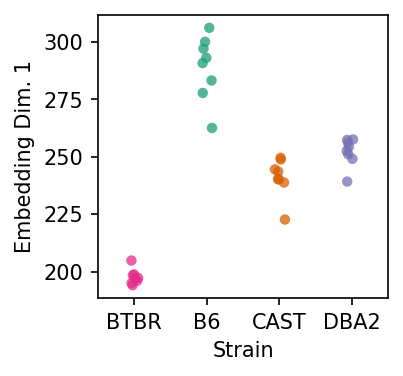

<IPython.core.display.Javascript object>

In [18]:
left_cc = omni.query("ROI == 121")[["omni_1", "genotype"]]
left_cc.columns = ["Embedding Dim. 1", "Strain"]
g = stripplot(left_cc, "Embedding Dim. 1")
plt.show()

## Identifying signal communities

In [19]:
from collections import namedtuple
from itertools import combinations_with_replacement

Point = namedtuple("Point", ["x", "y"])

<IPython.core.display.Javascript object>

In [20]:
def _get_point(community, hemisphere):
    """Make points from database queries."""
    expr = f"block == '{community}' and hemisphere == '{hemisphere}'"
    point = Point(*mice.blocks.query(expr).values[0][2:])
    return point

<IPython.core.display.Javascript object>

In [21]:
def _get_edges(point_1, point_2, sample):
    return sample[:, point_1.x : point_1.y, point_2.x : point_2.y].reshape(8, -1)

<IPython.core.display.Javascript object>

In [22]:
def _get_community_name(block, hemisphere):
    block = " ".join([struct.capitalize() for struct in block.split("_")])
    return f"{block} ({hemisphere})"

<IPython.core.display.Javascript object>

In [23]:
signal_communities = []

for (_, community_1), (_, community_2) in combinations_with_replacement(
    mice.blocks.iterrows(), r=2
):

    point_1 = _get_point(community_1.block, community_1.hemisphere)
    point_2 = _get_point(community_2.block, community_2.hemisphere)

    community_1 = _get_community_name(community_1.block, community_1.hemisphere)
    community_2 = _get_community_name(community_2.block, community_2.hemisphere)

    edges = [_get_edges(point_1, point_2, sample) for sample in connectomes]

    try:
        stat, pvalue = KSample("Dcorr").test(*edges)
    except ValueError as e:
        print(e)
        stat, pvalue = np.nan, 1

    signal_communities.append([community_1, community_2, stat, pvalue])

<IPython.core.display.Javascript object>

In [24]:
signal_communities = pd.DataFrame(
    signal_communities, columns=["Community 1", "Community 2", "statistic", "pvalue"]
)

# Correct p-values
signal_communities = signal_communities.sort_values(["pvalue"])
reject, holm_pvalue, _, _ = multipletests(
    signal_communities["pvalue"], alpha=0.05, method="holm"
)
signal_communities["holm_pvalue"] = holm_pvalue
signal_communities["significant"] = reject
signal_communities.head()

,Community 1,Community 2,statistic,pvalue,holm_pvalue,significant
104,White Matter (R),White Matter (R),0.887936,5.845560e-08,0.000006,True
103,Hindbrain (R),White Matter (R),0.872292,7.568970e-08,0.000008,True
69,White Matter (L),White Matter (L),0.870605,7.782855e-08,0.000008,True
94,Subpallium (R),White Matter (R),0.852299,1.053251e-07,0.000011,True
61,Hindbrain (L),White Matter (L),0.848059,1.129719e-07,0.000011,True


<IPython.core.display.Javascript object>

In [25]:
signal_communities.to_csv("../results/signal_communities.csv", index=False)

<IPython.core.display.Javascript object>

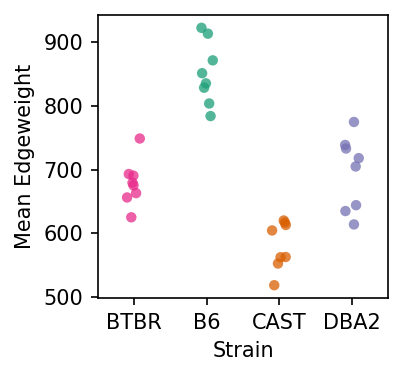

<IPython.core.display.Javascript object>

In [26]:
wm_r = _get_point("white_matter", "R")
wm_r_edgeweight = graphs[:, wm_r.x : wm_r.y, wm_r.x : wm_r.y].reshape(32, -1)
wm_r_mean = wm_r_edgeweight.mean(axis=1)

avg_connectivity = pd.DataFrame({"Mean Edgeweight": wm_r_mean, "Strain": labels})
g = stripplot(avg_connectivity, "Mean Edgeweight")
plt.show()